In [122]:
import numpy as np
import os
import cv2
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
import tensorflow.keras.applications
import keras_tuner 

SEED = 42
import random 
random.seed(SEED)
import numpy as np
np.random.seed(SEED)
import tensorflow as tf
tf.random.set_seed(SEED)

# ** Inputs **

In [123]:
# Choose which image folder name you want to use.
image_folder_name = 'FMD_tvt'

#image size
img_size = (150, 150)

#expected input shape Model, (FIRST TWO VALUES MUST BE THE SAME AS img_size)
img_shape = (150, 150, 3)

#Batch Size of Data
batch_size = 32

Model_save_name = 'MobilNet.h5'

# Setup of Paths and Values

In [124]:
tvt_folders = ['train', 'val', 'test']
im_folders = ['image', 'mask']

Fmd_class_path = os.path.join(image_folder_name, tvt_folders[0], im_folders[0])
classes = os.listdir(os.path.join(Fmd_class_path))
print(classes)

['fabric', 'foliage', 'glass', 'leather', 'metal', 'paper', 'plastic', 'stone', 'water', 'wood']


In [125]:
image_path_train = os.path.join(image_folder_name, tvt_folders[0], im_folders[0])
mask_path_train = os.path.join(image_folder_name, tvt_folders[0], im_folders[1])

image_path_val = os.path.join(image_folder_name, tvt_folders[1], im_folders[0])
mask_path_val = os.path.join(image_folder_name, tvt_folders[1], im_folders[1])

# Load in Data and Make Datasets

Define Three functions

In [126]:
def fun_load_image(x):
    byte_img = tf.io.read_file(x) #Tensorflow way of loading in image
    img = tf.io.decode_jpeg(byte_img)  #Need both lines of code
    return img

In [127]:
def make_dataset_imgs(tvt_folder, classes, img_size):
    ds = tf.data.Dataset.list_files(os.path.join(image_folder_name, tvt_folder, 'image', classes[0], "*.jpg"), shuffle=False)
    for i in range(len(classes)-1):
        ds_class = tf.data.Dataset.list_files(os.path.join(image_folder_name, tvt_folder, 'image', classes[i+1], "*.jpg"), shuffle=False)
        ds = ds.concatenate(ds_class)

    ds = ds.map(fun_load_image)
    ds = ds.map(lambda x: tf.image.resize(x, img_size))
    ds = ds.map(lambda x: x/255)
    return ds


In [128]:
def make_dataset_labels(image_path):
    class_labels = []
    for class_ in classes:
        class_val = classes.index(class_)
        num_in_class = len(os.listdir(os.path.join(image_path, class_)))
        class_labels_ = [class_val]*num_in_class
        class_labels = class_labels + class_labels_

    label_ds = tf.data.Dataset.from_tensor_slices(class_labels)
    return label_ds

Training Data

In [129]:
train_ds = make_dataset_imgs(tvt_folders[0], classes, img_size)
train_labels_ds = make_dataset_labels(image_path_train)

Validation Data

In [130]:
val_ds = make_dataset_imgs(tvt_folders[1], classes, img_size)
val_labels_ds = make_dataset_labels(image_path_val)

# Zipping and Shuffle

In [131]:
train = tf.data.Dataset.zip((train_ds, train_labels_ds))
train = train.shuffle(10000)

val = tf.data.Dataset.zip((val_ds, val_labels_ds))
val = val.shuffle(10000)


# Sanity Check

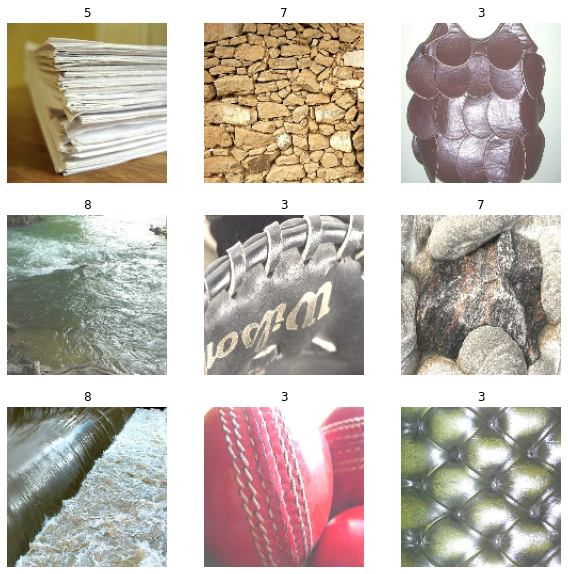

In [132]:
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(int(label))
    plt.axis("off")

# Batch and Prefetch

In [133]:
#Just speeds up the computation-Need to look into it more!!!
train = train.cache().batch(batch_size).prefetch(buffer_size=10)
val = val.cache().batch(batch_size).prefetch(buffer_size=10)

# Building Model

In [134]:
base_model = tf.keras.applications.Xception(
    weights = 'imagenet', 
    input_shape = (150, 150, 3), #State the size of the images
    include_top = False #Do not include the Imagenet Classifier at the top
)
base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 74, 74, 32)   864         ['input_3[0][0]']                
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 74, 74, 32)  128         ['block1_conv1[0][0]']           
 ation)                                                                                           
                                                                                           

# Keras Tuner

In [135]:
#Hyper Parameters that will be tuned.
min_neuron_range1, max_neuron_range1 = 128, 512
min_neuron_range2, max_neuron_range2 = 64, 256
min_neuron_range3, max_neuron_range3 = 16, 64
lr_range, lr_sampling= [0.0001, 0.01], 'log'
min_dropoutprob, max_dropoutprob = 0.1, 0.5

In [136]:
def build_model(dropout_prob, unit1, unit2, unit3):  
    # #Freeze the model
    base_model.trainable = False

    #Create a new model on top
    inputs = tf.keras.Input(shape = (150, 150, 3))

    x = base_model(inputs, training=False)

    x = tf.keras.layers.GlobalAveragePooling2D()(x) #Same job as flattening but in a different way. Bridges convolutional structure to traditional neural network
    x = tf.keras.layers.Dropout(dropout_prob)(x) # Regularize with dropout
    x = tf.keras.layers.Dense(unit1, activation= "relu")(x)
    x = tf.keras.layers.Dropout(dropout_prob)(x)
    x = tf.keras.layers.Dense(unit2, activation= "relu")(x)
    x = tf.keras.layers.Dropout(dropout_prob)(x)
    x = tf.keras.layers.Dense(unit3, activation= "relu")(x)

    outputs = tf.keras.layers.Dense(10, activation="softmax")(x)

    model = tf.keras.Model(inputs, outputs)

    return model

In [137]:
def buildmodel(hp):
    
    dropout_prob = hp.Float('dropout_prob', min_value = min_dropoutprob, max_value = max_dropoutprob, step = min_dropoutprob)
    units1 = hp.Int(name ='units1', min_value = min_neuron_range1, max_value = max_neuron_range1, step = min_neuron_range1)
    units2 = hp.Int(name ='units2', min_value = min_neuron_range2, max_value = max_neuron_range2, step = min_neuron_range2)
    units3 = hp.Int(name ='units3', min_value = min_neuron_range3, max_value = max_neuron_range3, step = min_neuron_range3)  

    model = build_model(dropout_prob, units1, units2, units3)
    
    #Define Optimizer (Appling Keras Tuner for the learning rate Parameter)
    learning_rate = hp.Float('lr', min_value = lr_range[0], max_value = lr_range[1], sampling = lr_sampling)

    model.compile(
    optimizer= tf.keras.optimizers.Adam(learning_rate= learning_rate), 
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
    return model

In [138]:
#Build the model
buildmodel(keras_tuner.HyperParameters())

tuner = keras_tuner.RandomSearch(
    hypermodel=buildmodel,
    objective="val_sparse_categorical_accuracy",
    max_trials=10,
    executions_per_trial = 1,
    overwrite = True
)

In [139]:
tuner.search_space_summary()

Search space summary
Default search space size: 5
dropout_prob (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': 0.1, 'sampling': None}
units1 (Int)
{'default': None, 'conditions': [], 'min_value': 128, 'max_value': 512, 'step': 128, 'sampling': None}
units2 (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 256, 'step': 64, 'sampling': None}
units3 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 64, 'step': 16, 'sampling': None}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [140]:
tuner.search(train, epochs = 50, validation_data=val, callbacks=[tf.keras.callbacks.EarlyStopping(patience=7, monitor='val_sparse_categorical_accuracy', restore_best_weights= True)])

Trial 1 Complete [00h 01m 40s]
val_sparse_categorical_accuracy: 0.6850000023841858

Best val_sparse_categorical_accuracy So Far: 0.6850000023841858
Total elapsed time: 00h 01m 40s
INFO:tensorflow:Oracle triggered exit


In [141]:
models = tuner.get_best_models(num_models=1)
# Get the top hyperparameters.
best_hps = tuner.get_best_hyperparameters(1)[0]

Best Parameters

# Actual Training

In [143]:
# Build the model with the best hp.
model = buildmodel(best_hps)

In [144]:
epochs = 50
history = model.fit(train, epochs = epochs, validation_data = val, callbacks=[tf.keras.callbacks.EarlyStopping(patience=7, monitor='val_sparse_categorical_accuracy', restore_best_weights= True)])

Epoch 1/50
19/19 [==============================] - 25s 1s/step - loss: 2.3656 - sparse_categorical_accuracy: 0.1323 - val_loss: 2.1191 - val_sparse_categorical_accuracy: 0.3150
Epoch 2/50
19/19 [==============================] - 20s 1s/step - loss: 2.1001 - sparse_categorical_accuracy: 0.2345 - val_loss: 1.9148 - val_sparse_categorical_accuracy: 0.5050
Epoch 3/50
19/19 [==============================] - 20s 1s/step - loss: 1.8736 - sparse_categorical_accuracy: 0.3585 - val_loss: 1.5406 - val_sparse_categorical_accuracy: 0.6450
Epoch 4/50
19/19 [==============================] - 19s 1s/step - loss: 1.6404 - sparse_categorical_accuracy: 0.4523 - val_loss: 1.2618 - val_sparse_categorical_accuracy: 0.6550
Epoch 5/50
19/19 [==============================] - 18s 933ms/step - loss: 1.3119 - sparse_categorical_accuracy: 0.5611 - val_loss: 1.0597 - val_sparse_categorical_accuracy: 0.7150
Epoch 6/50
19/19 [==============================] - 18s 933ms/step - loss: 1.1900 - sparse_categorical_accu

In [145]:
# Save the entire model as a SavedModel.
if not os.path.exists:
    os.makedirs('Models')
model.save(os.path.join('Models', "Tuned_"+Model_save_name))

# Final Validation Accuracy and Best Hyper Parameters Tuned

In [146]:
print(f'Final Validation Accuracy = {np.round(max(history.history["val_sparse_categorical_accuracy"]), 4)}')

Final Validation Accuracy = 0.77


In [147]:
print("Best Hyper Parameters:")
print(f"Units 1: {best_hps.get('units1')}")
print(f"Units 2: {best_hps.get('units2')}")
print(f"Units 3: {best_hps.get('units3')}")
print(f"DropOut prob: {best_hps.get('dropout_prob')}")
print(f"Learning Rate: {best_hps.get('lr')}")

Best Hyper Parameters:
Units 1: 384
Units 2: 128
Units 3: 48
DropOut prob: 0.4
Learning Rate: 0.000509655304274329
